In [1]:
import numpy as np
import itertools

## Helper to View Nested Dictionaries

In [2]:
levelsReward  = ["state", "action", "next state", "reward"]
levelsTransition  = ["state", "action", "next state", "probability"]

def viewDictionaryStructure(d, levels, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(levels[indent]) + ": "+ str(key))
        if isinstance(value, dict):
            viewDictionaryStructure(value, levels, indent+1)
        else:
            print('\t' * (indent+1) + str(levels[indent+1])+ ": " + str(value))

# Setup transition

In [3]:
class SetupTransition(object):
    def __init__(self, gridWidth, gridHeight, actionSet):
        self.gridWidth = gridWidth
        self.gridHeight = gridHeight
        self.stateSet = list(itertools.product(range(self.gridWidth), range(self.gridHeight)))
        self.actionSet = actionSet


    def __call__(self):
        transitionTable = {state: self.getStateTransition(state) for state in self.stateSet}
        return(transitionTable) 

    def getStateTransition(self, state):
        actionTransitionDistribution = {action: self.getStateActionTransition(state, action) for action in self.actionSet}
        return(actionTransitionDistribution)
    
    def getStateActionTransition(self, currentState, action):
        nextState = self.getNextState(currentState, action)
        
        #determinisitic transition
        #transitionDistribution = {nextState: 1}
            
        
        #probabilistic:
    
        validNextStates = list(set([self.getNextState(currentState, a) for a in self.actionSet]))
        rangeValidNextStates = len(validNextStates)
        slipStates = np.random.choice(rangeValidNextStates, 3)
        transitionDistribution = {nextState:.7}

        for slipIndex in slipStates:
            if validNextStates[slipIndex] not in transitionDistribution:
                transitionDistribution[validNextStates[slipIndex]] = .1
            else:
                transitionDistribution[validNextStates[slipIndex]] += .1
    
        return(transitionDistribution)

    
    def getNextState(self, state, action):
        potentialNextState = tuple([state[i] + action[i] for i in range(len(state))])
        if potentialNextState in self.stateSet:
            return(potentialNextState)
        return(state) 

# Setup Reward

In [4]:
class SetupRewardTable(object):
    def __init__(self,transitionTable, actionSet, goalState, trapState):
        self.transitionTable = transitionTable
        self.stateSet = list(transitionTable.keys())
        self.actionSet = actionSet
        self.goalState = goalState
        self.trapState = trapState
        
    def __call__(self):
        rewardTable = {state:{action:{nextState: self.applyRewardFunction(state, action, nextState) for nextState in nextStateDict.keys() }for action, nextStateDict in actionDict.items()} for state, actionDict in self.transitionTable.items()}
        return(rewardTable)

    def applyRewardFunction(self, state, action, nextState):
        goalReward = 10
        trapCost = -100
        moveCost = -1
        
        if state == self.goalState and nextState != self.goalState:
            return(goalReward)
        elif state == self.trapState:
            return(trapCost)
        return(moveCost)

# Perform Value Iteration

In [5]:
class ValueIteration(object):
    def __init__(self, transitionTable, rewardTable, valueTable, convergenceTolerance, discountingFactor = 1):
        self.transitionTable = transitionTable
        self.rewardTable  = rewardTable
        self.valueTable = valueTable
        self.convergenceTolerance = convergenceTolerance
        self.gamma = discountingFactor

    def __call__(self):
        
        theta = self.convergenceTolerance*100
        while(theta > self.convergenceTolerance):
            theta = 0
            for state, actionDict in self.transitionTable.items():
                valueOfStateAtTimeT = self.valueTable[state]
                qforAllActions = [self.getQValue(state, action) for action in actionDict.keys()]
                self.valueTable[state] = max(qforAllActions) 
                theta = max(theta, abs(valueOfStateAtTimeT-self.valueTable[state]))
        policyTable = {state:self.getStatePolicy(state) for state in self.transitionTable.keys()}

        return([self.valueTable, policyTable])
    
    def getStatePolicy(self, state):
        maxQValue = max([round(self.getQValue(state, action),5) for action in self.transitionTable[state].keys()])
        optimalActionSet = [action for action in self.transitionTable[state].keys() \
                            if round(self.getQValue(state, action),5) == maxQValue]
        statePolicy = {action: 1/(len(optimalActionSet)) for action in optimalActionSet}
        return(statePolicy)
        
    def getQValue(self, state, action):
        nextStatesQ = [prob*(self.rewardTable[state][action][nextState] \
                             + self.gamma*self.valueTable[nextState]) \
                      for nextState, prob in self.transitionTable[state][action].items()]
        qValue = sum(nextStatesQ)
        return(qValue)

# Visualize Value Table

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [7]:
def visualizeValueTable(gridWidth, gridHeight, goalState, trapState, valueTable):
    #grid height/width
    xs = np.linspace(-.5, gridWidth-.5, gridWidth+1)
    ys = np.linspace(-.50, gridHeight-.5, gridHeight+1)

    ax = plt.gca()

    #goal and trap coloring
    goal = (goalState[0]-.5, goalState[1]-.5)
    trap = (trapState[0]-.5, trapState[1]-.5)
    ax.add_patch(Rectangle(goal, 1, 1, fill=True, color='#008610', alpha=.1))
    ax.add_patch(Rectangle(trap, 1, 1, fill=True, color='red', alpha=.1))

    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color='black', alpha=.33)
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color='black', alpha=.33)

    for (statex, statey), val in valueTable.items():
        plt.text(statex, statey, str(round(val, 3)))    

    plt.show()

# Test Examples - Generated

## Example 1: Deterministic

In [8]:
gridWidth = 3 #4
gridHeight = 5 #3
allActions = [(1,0), (0,1), (-1,0), (0,-1)]
goalState = (1,1)
trapState = (1,2)

np.random.seed(1000)
getTransition = SetupTransition(gridWidth, gridHeight, allActions)
transition = getTransition()

getReward = SetupRewardTable(transition, allActions, goalState, trapState)
reward = getReward()

value = {state:0 for state in reward.keys()}


performValueIteration = ValueIteration(transition, reward, value, .000001, .9)
optimalValues, policy = performValueIteration()

In [9]:
viewDictionaryStructure(transition, levelsTransition)

state: (0, 0)
	action: (1, 0)
		next state: (1, 0)
			probability: 0.7
		next state: (0, 1)
			probability: 0.2
		next state: (0, 0)
			probability: 0.1
	action: (0, 1)
		next state: (0, 1)
			probability: 0.7999999999999999
		next state: (1, 0)
			probability: 0.2
	action: (-1, 0)
		next state: (0, 0)
			probability: 0.7
		next state: (1, 0)
			probability: 0.2
		next state: (0, 1)
			probability: 0.1
	action: (0, -1)
		next state: (0, 0)
			probability: 0.7
		next state: (1, 0)
			probability: 0.1
		next state: (0, 1)
			probability: 0.2
state: (0, 1)
	action: (1, 0)
		next state: (1, 1)
			probability: 0.7999999999999999
		next state: (0, 1)
			probability: 0.1
		next state: (0, 2)
			probability: 0.1
	action: (0, 1)
		next state: (0, 2)
			probability: 0.7999999999999999
		next state: (0, 0)
			probability: 0.2
	action: (-1, 0)
		next state: (0, 1)
			probability: 0.8999999999999999
		next state: (0, 0)
			probability: 0.1
	action: (0, -1)
		next state: (0, 0)
			probability: 0.799

In [10]:
viewDictionaryStructure(reward, levelsReward)

state: (0, 0)
	action: (1, 0)
		next state: (1, 0)
			reward: -1
		next state: (0, 1)
			reward: -1
		next state: (0, 0)
			reward: -1
	action: (0, 1)
		next state: (0, 1)
			reward: -1
		next state: (1, 0)
			reward: -1
	action: (-1, 0)
		next state: (0, 0)
			reward: -1
		next state: (1, 0)
			reward: -1
		next state: (0, 1)
			reward: -1
	action: (0, -1)
		next state: (0, 0)
			reward: -1
		next state: (1, 0)
			reward: -1
		next state: (0, 1)
			reward: -1
state: (0, 1)
	action: (1, 0)
		next state: (1, 1)
			reward: -1
		next state: (0, 1)
			reward: -1
		next state: (0, 2)
			reward: -1
	action: (0, 1)
		next state: (0, 2)
			reward: -1
		next state: (0, 0)
			reward: -1
	action: (-1, 0)
		next state: (0, 1)
			reward: -1
		next state: (0, 0)
			reward: -1
	action: (0, -1)
		next state: (0, 0)
			reward: -1
		next state: (0, 2)
			reward: -1
		next state: (0, 1)
			reward: -1
state: (0, 2)
	action: (1, 0)
		next state: (1, 2)
			reward: -1
		next state: (0, 1)
			reward: -1
	acti

In [11]:
value = {state:0 for state in reward.keys()}
value

{(0, 0): 0,
 (0, 1): 0,
 (0, 2): 0,
 (0, 3): 0,
 (0, 4): 0,
 (1, 0): 0,
 (1, 1): 0,
 (1, 2): 0,
 (1, 3): 0,
 (1, 4): 0,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): 0,
 (2, 3): 0,
 (2, 4): 0}

In [12]:
optimalValues

{(0, 0): 31.047706066492907,
 (0, 1): 35.58011478441525,
 (0, 2): 30.101609823335988,
 (0, 3): 25.35241003401624,
 (0, 4): 20.087706249055625,
 (1, 0): 35.72235612216954,
 (1, 1): 42.59550025508376,
 (1, 2): -62.735580351190755,
 (1, 3): 21.890068076220413,
 (1, 4): 18.376636139708708,
 (2, 0): 31.539827786942368,
 (2, 1): 36.34093970744266,
 (2, 2): 30.689605473741494,
 (2, 3): 25.75740523673678,
 (2, 4): 21.098053826030437}

In [13]:
policy

{(0, 0): {(0, 1): 1.0},
 (0, 1): {(1, 0): 1.0},
 (0, 2): {(0, -1): 1.0},
 (0, 3): {(0, -1): 1.0},
 (0, 4): {(0, -1): 1.0},
 (1, 0): {(0, 1): 1.0},
 (1, 1): {(1, 0): 1.0},
 (1, 2): {(0, -1): 1.0},
 (1, 3): {(-1, 0): 1.0},
 (1, 4): {(0, -1): 1.0},
 (2, 0): {(0, 1): 1.0},
 (2, 1): {(-1, 0): 1.0},
 (2, 2): {(0, -1): 1.0},
 (2, 3): {(0, -1): 1.0},
 (2, 4): {(0, -1): 1.0}}

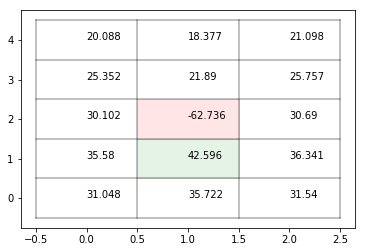

In [14]:
visualizeValueTable(gridWidth, gridHeight, goalState, trapState, optimalValues)

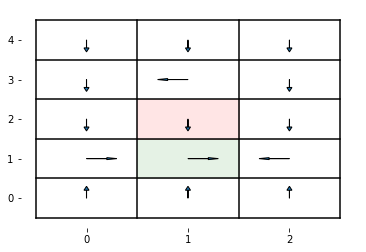

In [15]:
#grid height/width
xs = np.linspace(-.5, gridWidth-.5, gridWidth+1)
ys = np.linspace(-.50, gridHeight-.5, gridHeight+1)

ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

#goal and trap coloring 
ax.add_patch(Rectangle((goalState[0]-.5, goalState[1]-.5), 1, 1, fill=True, color='green', alpha=.1))
ax.add_patch(Rectangle((trapState[0]-.5, trapState[1]-.5), 1, 1, fill=True, color='red', alpha=.1))

# grid lines
for x in xs:
    plt.plot([x, x], [ys[0], ys[-1]], color = "black")
for y in ys:
    plt.plot([xs[0], xs[-1]], [y, y], color = "black")

#labeled values
for (statex, statey), actionDict in policy.items():
    for (optimalActionX, optimalActionY) in actionDict.keys():
        plt.arrow(statex, statey, optimalActionX*.2, optimalActionY*.2, head_width=0.05, head_length=0.1)    

plt.show()

## Example 2: Stochastic

In [16]:
gridWidth = 4
gridHeight = 4
allActions = [(1,0), (0,1), (-1,0), (0,-1)]
goalState = (3,1)
trapState = (1,1)

np.random.seed(1000)
getTransition = SetupTransition(gridWidth, gridHeight, allActions)
transition = getTransition()

getReward = SetupRewardTable(transition, allActions, goalState, trapState)
reward = getReward()

value = {state:0 for state in reward.keys()}


performValueIteration = ValueIteration(transition, reward, value, .0001, .9)
optimalValues, policy = performValueIteration()

In [17]:
optimalValues

{(0, 0): 2.6587194766073097,
 (0, 1): 3.492329815550675,
 (0, 2): 5.574740934782747,
 (0, 3): 7.549999674676594,
 (1, 0): 4.429980579936661,
 (1, 1): -93.81787071344016,
 (1, 2): 8.25856948811252,
 (1, 3): 9.93620091164332,
 (2, 0): 17.127967494846455,
 (2, 1): 3.627001516200856,
 (2, 2): 13.447797676150813,
 (2, 3): 12.705187457925808,
 (3, 0): 20.477171738855777,
 (3, 1): 25.547471878717705,
 (3, 2): 20.716983733493677,
 (3, 3): 16.203162030542092}

In [18]:
policy

{(0, 0): {(1, 0): 1.0},
 (0, 1): {(0, 1): 1.0},
 (0, 2): {(1, 0): 1.0},
 (0, 3): {(1, 0): 1.0},
 (1, 0): {(1, 0): 1.0},
 (1, 1): {(0, 1): 1.0},
 (1, 2): {(0, 1): 1.0},
 (1, 3): {(1, 0): 1.0},
 (2, 0): {(1, 0): 1.0},
 (2, 1): {(0, 1): 1.0},
 (2, 2): {(1, 0): 1.0},
 (2, 3): {(1, 0): 1.0},
 (3, 0): {(0, 1): 1.0},
 (3, 1): {(0, 1): 1.0},
 (3, 2): {(0, -1): 1.0},
 (3, 3): {(0, -1): 1.0}}

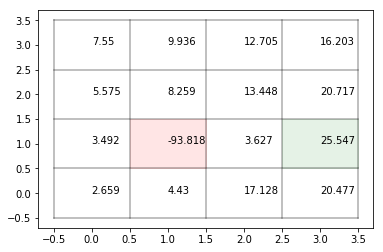

In [19]:
visualizeValueTable(gridWidth, gridHeight, goalState, trapState, optimalValues)

In [20]:
gridWidth = 5 #4
gridHeight = 5 #3
allActions = [(1,0), (0,1), (-1,0), (0,-1)]
goalStateTest = (3,1)
trapStateTest = (1,1)

np.random.seed(1000)
getTransition = SetupTransition(gridWidth, gridHeight, allActions)
transitionTest = getTransition()

getReward = SetupRewardTable(transitionTest, allActions, goalStateTest, trapStateTest)
rewardTest = getReward()

valueTest = {state:0 for state in rewardTest.keys()}


performValueIterationTest = ValueIteration(transitionTest, rewardTest, valueTest, .000001, .9)
optimalValuesTest, policyTest = performValueIterationTest()

In [25]:
policyTest

{(0, 0): {(1, 0): 1.0},
 (0, 1): {(0, -1): 1.0},
 (0, 2): {(0, -1): 1.0},
 (0, 3): {(1, 0): 1.0},
 (0, 4): {(1, 0): 1.0},
 (1, 0): {(1, 0): 1.0},
 (1, 1): {(1, 0): 1.0},
 (1, 2): {(1, 0): 1.0},
 (1, 3): {(1, 0): 1.0},
 (1, 4): {(1, 0): 1.0},
 (2, 0): {(1, 0): 1.0},
 (2, 1): {(0, -1): 1.0},
 (2, 2): {(1, 0): 1.0},
 (2, 3): {(0, -1): 1.0},
 (2, 4): {(1, 0): 1.0},
 (3, 0): {(0, 1): 1.0},
 (3, 1): {(0, -1): 1.0},
 (3, 2): {(0, -1): 1.0},
 (3, 3): {(0, -1): 1.0},
 (3, 4): {(0, -1): 1.0},
 (4, 0): {(0, 1): 1.0},
 (4, 1): {(-1, 0): 1.0},
 (4, 2): {(0, -1): 1.0},
 (4, 3): {(0, -1): 1.0},
 (4, 4): {(0, -1): 1.0}}

## Examples Raw Inputs:

In [21]:
"""
    Example 1: Deterministic Transition
"""
transitionTableDet = {(0, 0): {(1, 0): {(1, 0): 1},(0, 1): {(0, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(0, 0): 1}},(0, 1): {(1, 0): {(1, 1): 1},(0, 1): {(0, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(0, 0): 1}},(0, 2): {(1, 0): {(1, 2): 1},(0, 1): {(0, 2): 1},(-1, 0): {(0, 2): 1},(0, -1): {(0, 1): 1}},(1, 0): {(1, 0): {(2, 0): 1},(0, 1): {(1, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(1, 0): 1}},(1, 1): {(1, 0): {(2, 1): 1},(0, 1): {(1, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(1, 0): 1}},(1, 2): {(1, 0): {(2, 2): 1},(0, 1): {(1, 2): 1},(-1, 0): {(0, 2): 1},(0, -1): {(1, 1): 1}},(2, 0): {(1, 0): {(3, 0): 1},(0, 1): {(2, 1): 1},(-1, 0): {(1, 0): 1},(0, -1): {(2, 0): 1}},(2, 1): {(1, 0): {(3, 1): 1},(0, 1): {(2, 2): 1},(-1, 0): {(1, 1): 1},(0, -1): {(2, 0): 1}},(2, 2): {(1, 0): {(3, 2): 1},(0, 1): {(2, 2): 1},(-1, 0): {(1, 2): 1},(0, -1): {(2, 1): 1}},(3, 0): {(1, 0): {(3, 0): 1},(0, 1): {(3, 1): 1},(-1, 0): {(2, 0): 1},(0, -1): {(3, 0): 1}},(3, 1): {(1, 0): {(3, 1): 1},(0, 1): {(3, 2): 1},(-1, 0): {(2, 1): 1},(0, -1): {(3, 0): 1}},(3, 2): {(1, 0): {(3, 2): 1},(0, 1): {(3, 2): 1},(-1, 0): {(2, 2): 1},(0, -1): {(3, 1): 1}}}
rewardTableDet = {(0, 0): {(1, 0): {(1, 0): -1},(0, 1): {(0, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1}},(0, 1): {(1, 0): {(1, 1): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1}},(0, 2): {(1, 0): {(1, 2): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1}},(1, 0): {(1, 0): {(2, 0): -1},(0, 1): {(1, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(1, 0): -1}},(1, 1): {(1, 0): {(2, 1): 10},(0, 1): {(1, 2): 10},(-1, 0): {(0, 1): 10},(0, -1): {(1, 0): 10}},(1, 2): {(1, 0): {(2, 2): -100},(0, 1): {(1, 2): -1},(-1, 0): {(0, 2): -100},(0, -1): {(1, 1): -100}},(2, 0): {(1, 0): {(3, 0): -1},(0, 1): {(2, 1): -1},(-1, 0): {(1, 0): -1},(0, -1): {(2, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 1): -1},(0, -1): {(2, 0): -1}},(2, 2): {(1, 0): {(3, 2): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 2): -1},(0, -1): {(2, 1): -1}},(3, 0): {(1, 0): {(3, 0): -1},(0, 1): {(3, 1): -1},(-1, 0): {(2, 0): -1},(0, -1): {(3, 0): -1}},(3, 1): {(1, 0): {(3, 1): -1},(0, 1): {(3, 2): -1},(-1, 0): {(2, 1): -1},(0, -1): {(3, 0): -1}},(3, 2): {(1, 0): {(3, 2): -1},(0, 1): {(3, 2): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1}}}
valueTableDet = {(0, 0): 0,(0, 1): 0,(0, 2): 0,(1, 0): 0,(1, 1): 0,(1, 2): 0,(2, 0): 0,(2, 1): 0,(2, 2): 0,(3, 0): 0,(3, 1): 0,(3, 2): 0}
convergenceTolerance = .0001
gamma = .9


"""
    Example 2: Probabilistic Transition
"""
transitionTable = {(0, 0): {(1, 0): {(1, 0): 0.7, (0, 1): 0.2, (0, 0): 0.1},(0, 1): {(0, 1): 0.7999999999999999, (1, 0): 0.2},(-1, 0): {(0, 0): 0.7, (1, 0): 0.2, (0, 1): 0.1},(0, -1): {(0, 0): 0.7, (1, 0): 0.1, (0, 1): 0.2}},(0, 1): {(1, 0): {(1, 1): 0.7999999999999999, (0, 1): 0.1, (0, 2): 0.1},(0, 1): {(0, 2): 0.7999999999999999, (0, 0): 0.2},(-1, 0): {(0, 1): 0.8999999999999999, (0, 0): 0.1},(0, -1): {(0, 0): 0.7999999999999999, (0, 2): 0.1, (0, 1): 0.1}},(0, 2): {(1, 0): {(1, 2): 0.7999999999999999, (0, 1): 0.2},(0, 1): {(0, 3): 0.7999999999999999, (0, 1): 0.1, (1, 2): 0.1},(-1, 0): {(0, 2): 0.7, (0, 1): 0.1, (1, 2): 0.1, (0, 3): 0.1},(0, -1): {(0, 1): 0.8999999999999999, (0, 3): 0.1}},(0, 3): {(1, 0): {(1, 3): 0.8999999999999999, (0, 2): 0.1},(0, 1): {(0, 3): 0.9999999999999999},(-1, 0): {(0, 3): 0.7999999999999999, (0, 2): 0.1, (1, 3): 0.1},(0, -1): {(0, 2): 0.7999999999999999, (0, 3): 0.2}},(1, 0): {(1, 0): {(2, 0): 0.8999999999999999, (1, 1): 0.1},(0, 1): {(1, 1): 0.8999999999999999, (1, 0): 0.1},(-1, 0): {(0, 0): 0.7, (1, 1): 0.2, (2, 0): 0.1},(0, -1): {(1, 0): 0.7999999999999999, (0, 0): 0.2}},(1, 1): {(1, 0): {(2, 1): 0.7999999999999999, (1, 0): 0.1, (0, 1): 0.1},(0, 1): {(1, 2): 0.7, (2, 1): 0.30000000000000004},(-1, 0): {(0, 1): 0.7, (2, 1): 0.1, (1, 0): 0.2},(0, -1): {(1, 0): 0.7999999999999999, (0, 1): 0.1, (2, 1): 0.1}},(1, 2): {(1, 0): {(2, 2): 0.7999999999999999, (1, 3): 0.1, (1, 1): 0.1},(0, 1): {(1, 3): 0.8999999999999999, (2, 2): 0.1},(-1, 0): {(0, 2): 0.8999999999999999, (1, 1): 0.1},(0, -1): {(1, 1): 0.7999999999999999, (2, 2): 0.1, (0, 2): 0.1}},(1, 3): {(1, 0): {(2, 3): 0.7999999999999999, (1, 3): 0.2},(0, 1): {(1, 3): 0.7999999999999999, (2, 3): 0.1, (0, 3): 0.1},(-1, 0): {(0, 3): 0.7, (2, 3): 0.1, (1, 2): 0.2},(0, -1): {(1, 2): 0.7999999999999999, (0, 3): 0.2}},(2, 0): {(1, 0): {(3, 0): 0.8999999999999999, (2, 0): 0.1},(0, 1): {(2, 1): 0.7999999999999999, (3, 0): 0.1, (1, 0): 0.1},(-1, 0): {(1, 0): 0.7, (2, 0): 0.2, (2, 1): 0.1},(0, -1): {(2, 0): 0.7, (2, 1): 0.2, (1, 0): 0.1}},(2, 1): {(1, 0): {(3, 1): 0.7999999999999999, (1, 1): 0.2},(0, 1): {(2, 2): 0.7, (1, 1): 0.1, (3, 1): 0.2},(-1, 0): {(1, 1): 0.7, (2, 0): 0.1, (2, 2): 0.1, (3, 1): 0.1},(0, -1): {(2, 0): 0.7, (1, 1): 0.2, (3, 1): 0.1}},(2, 2): {(1, 0): {(3, 2): 0.7, (1, 2): 0.1, (2, 1): 0.2},(0, 1): {(2, 3): 0.7999999999999999, (2, 1): 0.2},(-1, 0): {(1, 2): 0.7999999999999999, (2, 1): 0.1, (3, 2): 0.1},(0, -1): {(2, 1): 0.7999999999999999, (1, 2): 0.1, (3, 2): 0.1}},(2, 3): {(1, 0): {(3, 3): 0.7, (2, 3): 0.2, (2, 2): 0.1},(0, 1): {(2, 3): 0.7999999999999999, (2, 2): 0.1, (3, 3): 0.1},(-1, 0): {(1, 3): 0.8999999999999999, (2, 3): 0.1},(0, -1): {(2, 2): 0.7, (3, 3): 0.1, (1, 3): 0.1, (2, 3): 0.1}},(3, 0): {(1, 0): {(3, 0): 0.7, (3, 1): 0.1, (2, 0): 0.2},(0, 1): {(3, 1): 0.7999999999999999, (2, 0): 0.2},(-1, 0): {(2, 0): 0.7999999999999999, (3, 0): 0.2},(0, -1): {(3, 0): 0.7999999999999999, (2, 0): 0.1, (3, 1): 0.1}},(3, 1): {(1, 0): {(3, 1): 0.8999999999999999, (3, 2): 0.1},(0, 1): {(3, 2): 0.7, (2, 1): 0.2, (3, 0): 0.1},(-1, 0): {(2, 1): 0.7999999999999999, (3, 0): 0.1, (3, 1): 0.1},(0, -1): {(3, 0): 0.7999999999999999, (2, 1): 0.2}},(3, 2): {(1, 0): {(3, 2): 0.7999999999999999, (3, 1): 0.1, (2, 2): 0.1},(0, 1): {(3, 3): 0.7, (3, 2): 0.2, (2, 2): 0.1},(-1, 0): {(2, 2): 0.9999999999999999},(0, -1): {(3, 1): 0.7999999999999999, (3, 3): 0.1, (3, 2): 0.1}},(3, 3): {(1, 0): {(3, 3): 0.7999999999999999, (3, 2): 0.2},(0, 1): {(3, 3): 0.7999999999999999, (3, 2): 0.2},(-1, 0): {(2, 3): 0.7999999999999999, (3, 2): 0.1, (3, 3): 0.1},(0, -1): {(3, 2): 0.7999999999999999, (2, 3): 0.2}}}
rewardTable = {(0, 0): {(1, 0): {(1, 0): -1, (0, 1): -1, (0, 0): -1},(0, 1): {(0, 1): -1, (1, 0): -1},(-1, 0): {(0, 0): -1, (1, 0): -1, (0, 1): -1},(0, -1): {(0, 0): -1, (1, 0): -1, (0, 1): -1}},(0, 1): {(1, 0): {(1, 1): -1, (0, 1): -1, (0, 2): -1},(0, 1): {(0, 2): -1, (0, 0): -1},(-1, 0): {(0, 1): -1, (0, 0): -1},(0, -1): {(0, 0): -1, (0, 2): -1, (0, 1): -1}},(0, 2): {(1, 0): {(1, 2): -1, (0, 1): -1},(0, 1): {(0, 3): -1, (0, 1): -1, (1, 2): -1},(-1, 0): {(0, 2): -1, (0, 1): -1, (1, 2): -1, (0, 3): -1},(0, -1): {(0, 1): -1, (0, 3): -1}},(0, 3): {(1, 0): {(1, 3): -1, (0, 2): -1},(0, 1): {(0, 3): -1},(-1, 0): {(0, 3): -1, (0, 2): -1, (1, 3): -1},(0, -1): {(0, 2): -1, (0, 3): -1}},(1, 0): {(1, 0): {(2, 0): -1, (1, 1): -1},(0, 1): {(1, 1): -1, (1, 0): -1},(-1, 0): {(0, 0): -1, (1, 1): -1, (2, 0): -1},(0, -1): {(1, 0): -1, (0, 0): -1}},(1, 1): {(1, 0): {(2, 1): -100, (1, 0): -100, (0, 1): -100},(0, 1): {(1, 2): -100, (2, 1): -100},(-1, 0): {(0, 1): -100, (2, 1): -100, (1, 0): -100},(0, -1): {(1, 0): -100, (0, 1): -100, (2, 1): -100}},(1, 2): {(1, 0): {(2, 2): -1, (1, 3): -1, (1, 1): -1},(0, 1): {(1, 3): -1, (2, 2): -1},(-1, 0): {(0, 2): -1, (1, 1): -1},(0, -1): {(1, 1): -1, (2, 2): -1, (0, 2): -1}},(1, 3): {(1, 0): {(2, 3): -1, (1, 3): -1},(0, 1): {(1, 3): -1, (2, 3): -1, (0, 3): -1},(-1, 0): {(0, 3): -1, (2, 3): -1, (1, 2): -1},(0, -1): {(1, 2): -1, (0, 3): -1}},(2, 0): {(1, 0): {(3, 0): -1, (2, 0): -1},(0, 1): {(2, 1): -1, (3, 0): -1, (1, 0): -1},(-1, 0): {(1, 0): -1, (2, 0): -1, (2, 1): -1},(0, -1): {(2, 0): -1, (2, 1): -1, (1, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1, (1, 1): -1},(0, 1): {(2, 2): -1, (1, 1): -1, (3, 1): -1},(-1, 0): {(1, 1): -1, (2, 0): -1, (2, 2): -1, (3, 1): -1},(0, -1): {(2, 0): -1, (1, 1): -1, (3, 1): -1}},(2, 2): {(1, 0): {(3, 2): -1, (1, 2): -1, (2, 1): -1},(0, 1): {(2, 3): -1, (2, 1): -1},(-1, 0): {(1, 2): -1, (2, 1): -1, (3, 2): -1},(0, -1): {(2, 1): -1, (1, 2): -1, (3, 2): -1}},(2, 3): {(1, 0): {(3, 3): -1, (2, 3): -1, (2, 2): -1},(0, 1): {(2, 3): -1, (2, 2): -1, (3, 3): -1},(-1, 0): {(1, 3): -1, (2, 3): -1},(0, -1): {(2, 2): -1, (3, 3): -1, (1, 3): -1, (2, 3): -1}},(3, 0): {(1, 0): {(3, 0): -1, (3, 1): -1, (2, 0): -1},(0, 1): {(3, 1): -1, (2, 0): -1},(-1, 0): {(2, 0): -1, (3, 0): -1},(0, -1): {(3, 0): -1, (2, 0): -1, (3, 1): -1}},(3, 1): {(1, 0): {(3, 1): -1, (3, 2): 10},(0, 1): {(3, 2): 10, (2, 1): 10, (3, 0): 10},(-1, 0): {(2, 1): 10, (3, 0): 10, (3, 1): -1},(0, -1): {(3, 0): 10, (2, 1): 10}},(3, 2): {(1, 0): {(3, 2): -1, (3, 1): -1, (2, 2): -1},(0, 1): {(3, 3): -1, (3, 2): -1, (2, 2): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1, (3, 3): -1, (3, 2): -1}},(3, 3): {(1, 0): {(3, 3): -1, (3, 2): -1},(0, 1): {(3, 3): -1, (3, 2): -1},(-1, 0): {(2, 3): -1, (3, 2): -1, (3, 3): -1},(0, -1): {(3, 2): -1, (2, 3): -1}}}
valueTable = {(0, 0): 0,(0, 1): 0,(0, 2): 0,(0, 3): 0,(1, 0): 0,(1, 1): 0,(1, 2): 0,(1, 3): 0,(2, 0): 0,(2, 1): 0,(2, 2): 0,(2, 3): 0,(3, 0): 0,(3, 1): 0,(3, 2): 0,(3, 3): 0}
convergenceTolerance = .0001
gamma = .9